## SEP 769 Part 2 of Project - Generate Realistic Human Face using GAN  <br>

Authors			    :	Kyaw Kyaw Oo, Hariharan Mohan, Faizan Parabtani<br>
Student Numbers	    : 	400551761, 400608376, 400489257<br>
Group No			:   5	<br>x
Date of Submission	: 	Nov 28, 2024<br>
Lecturer			:	Dr. Alireza Fatehi <br>
                        Dr. Amir Pourhajiaghashafti <br>

CopyRight@2024 by Group 5 of SEP 769 Part 2<br>

# Version Management
Start Date :  19/11/2024   <br>
Version : 1      <br>
Released Date: 24/11/2024   <br>
Major Changes:  Draft GAN and Basic Metrics  <br>
Minor Changes:    Integrting these two parts<br>

Version : 2      <br>
Released Date:    26/11/2024<br>
Major Changes:    Reduced size of Input Images due to the Computation Constraints as expected as well as not avaiable free instances of GPU and TPU in Colab and Kaggle<br>
Minor Changes:    Optimizing the Batches and Epochs as 1sy round<br>

Version : 3      <br>
Released Date:    29/11/2024<br>
Major Changes:    Adding Train GAN and its Error Metrics<br>
Minor Changes:    Optimizing the Parameters for Generator and Discriminator<br>

Version : 4      <br>
Released Date:    30/11/2024<br>
Major Changes:    Improving the Generated Image Quality via Generator and Discriminator Layers<br>
Minor Changes:    Fine tuning the Losses Plot, IScore and FID<br>

Version : 5      <br>
Released Date:   01/12/2024 <br>
Major Changes:    Improving the Generated Image Quality but it was not happened so much yet<br>
Minor Changes:    Added some weight balancing approch<br>

Version : 6      <br>
Released Date:    01/12/2024<br>
Major Changes:    Remove the generated image module parts<br>
Minor Changes:    Procced as if approach due to the dead line with computation demand for the better generated image quality<br>

Version : 7 as Final Version 1     <br>
Released Date:    02/12/2024<br>
Major Changes:    Refactor, Clean Up Code and Format<br>
Minor Changes:    Increase the no of Epochs to have better result<br>

Version : 8 as Final Version 2   <br>
Released Date:    03/12/2024<br>
Major Changes:    Added Precision and Recall as well as KID<br>
Minor Changes:    <br>

Version : 9 as Final Version 3   <br>
Released Date:    04/12/2024<br>
Major Changes:    Added readme.md<br>
Minor Changes:    <br>


The goal of this project is to build a generative model, in particular a GAN to create images of faces using the CelebA dataset that contains more than twenty thousand face images of celebrities with their attributes. To achieve this, the primary objective is to train the GAN to generate realistic-style images which are then realistically photorealistic with a focus on the realistic style portrayal of human faces in any conceivable emotion. GAN mainly includes a generator that generates synthetic image set and a discriminator that evaluates their authenticity. The generator enhances image production while the discriminator enhances the identification ability between the real image and the synthetic images during the Adversarial training. To evaluate the qualities of generated images, two indices, Inception Score (IS) and Fréchet Inception Distance (FID) will be used. Further experiments will focus on other attributes and features of the face including additional possible expressions to further demonstrate the versatility of the GAN synthesizing capability. This project facilitates the development of the existing field of generative modeling as it proves that GANs are efficient in the generation of high fidelity faces and assesses some of the capabilities of the network for mimicking intricate human features. 

# Clear the not compatiable packages  

In [1]:
# Clearing the unnecessary packages due to the dependency issues
%pip uninstall keras tensorflow tensorflow-addons -y


Found existing installation: keras 3.7.0
Uninstalling keras-3.7.0:
  Successfully uninstalled keras-3.7.0
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Loading the necessary packages
%pip install tensorflow scipy numpy pillow
%pip install pydot graphviz
# %pip install tensorflow-addons
#%pip install --upgrade tensorflow-addons
#%pip install tensorflow-addons==0.19.0

  Using cached tensorflow-2.18.0-cp39-cp39-macosx_12_0_arm64.whl.metadata (4.0 kB)
  Using cached keras-3.7.0-py3-none-any.whl.metadata (5.8 kB)
Using cached tensorflow-2.18.0-cp39-cp39-macosx_12_0_arm64.whl (239.4 MB)
Using cached keras-3.7.0-py3-none-any.whl (1.2 MB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Upgrading the existing packegs make it compatiable
%pip install --upgrade pydot

Note: you may need to restart the kernel to use updated packages.


# Loading Necessary Libraries

In [4]:
# Loading base library
import os
import time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


In [5]:
# Loading additional library
from tqdm import tqdm
from PIL import Image
from scipy.linalg import sqrtm

In [6]:
# Loading Machine Learning Library
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances

In [7]:
# Loading Deeplearning library
# Keras
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization, ReLU
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model

#Torch
import torch
import torch.nn.functional as F
from torchvision import transforms, models

In [8]:
# Verifying the right and compatiable packages for the work
import tensorflow as tf
print(tf.__version__)

2.18.0


In [9]:
# Getting right location
current_directory = os.getcwd()
print("Current directory:", current_directory)

Current directory: /Users/kyawkyawoo/Documents/Automation and Smart System/769 CyperSecurity Physical/Projects/2


# Global Variables

In [10]:
# Constants
Real_Images_DIR = current_directory + '/Data/Images'
IMAGES_COUNT = 100   # Adjust based on available data due to the computational constraints in our local machine
WIDTH = 64           # Image width after resizing
HEIGHT = 64          # Image height after resizing
LATENT_DIM = 32      # Latent dimension for GAN
CHANNELS = 3         # Number of channels (RGB)
CONTROL_SIZE_SQRT = 6
RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'

# Predefined Modules

In [11]:
# Function to load custom images from a folder
def load_images_from_folder(folder_path, image_size=(64, 64)):
    """Load and preprocess images from a given folder."""
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)

        # Check if the file is an image by checking the file extension
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
            try:
                with Image.open(img_path) as img:
                    img = img.resize(image_size)  # Resize image to the target size
                    images.append(np.array(img))
            except Exception as e:
                print(f"Could not load image {filename}: {e}")
        else:
            # Optionally print the name of non-image files that are skipped
            print(f"Skipping non-image file: {filename}")

    # Normalize images to range [0, 1] and convert to float32
    return np.array(images).astype("float32") / 255.0

In [12]:
#
# Function to preprocess image for InceptionV3
def preprocess_image(img):
    img = img.resize((299, 299))  # Resize to 299x299 (required by InceptionV3)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Normalize image as required by InceptionV3
    return img_array

In [13]:
#
# Function to extract features from images using InceptionV3
# Load a pre-trained InceptionV3 model (exclude top layer to get features)
inception_model = InceptionV3(include_top=False, weights='imagenet', pooling='avg')

def extract_features(image_array):
    features = inception_model.predict(image_array)
    return features

In [14]:
# Function to generate real image features
def get_real_features(folder_path):
    real_images = load_images_from_folder(folder_path, image_size=(299, 299))  # Load and resize images to 299x299
    real_features = []

    for img in real_images:
        img = Image.fromarray((img * 255).astype(np.uint8))  # Convert back to PIL image (from normalized range [0,1])
        preprocessed_img = preprocess_image(img)
        features = extract_features(preprocessed_img)
        real_features.append(features)

    return np.array(real_features).reshape(len(real_features), -1)  # Reshape to (N, D)


In [15]:
# Generate images from the GAN model
def generate_images(generator, num_images=100, latent_dim=LATENT_DIM):
    """Generate images from the trained generator."""
    latent_vectors = np.random.normal(size=(num_images, latent_dim))  # Sample from normal distribution
    generated_images = generator.predict(latent_vectors)  # Generate images from latent vectors
    return generated_images

In [16]:
# Function to generate features for generated images
def get_generated_features(generator, num_images=100, latent_dim=LATENT_DIM):
    generated_images = generate_images(generator, num_images=num_images, latent_dim=latent_dim)
    generated_features = []

    for img in generated_images:
        img = Image.fromarray((img * 255).astype(np.uint8))  # Convert to PIL image (if needed)
        preprocessed_img = preprocess_image(img)
        features = extract_features(preprocessed_img)
        generated_features.append(features)

    return np.array(generated_features).reshape(len(generated_features), -1)  # Reshape to (M, D)

In [17]:
# Function to display images
def display_images(images, rows=5, cols=5):
    """Display first few images."""
    plt.figure(figsize=(10, 10))
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

# Creating the Generator

In [18]:
# Modified Generator to output (64, 64, 3) images
def create_generator(latent_dim=LATENT_DIM, channels=CHANNELS, height=HEIGHT, width=WIDTH):
    """Create the generator model that outputs images of size (64, 64, 3)."""
    gen_input = Input(shape=(latent_dim,))
    x = Dense(128 * 8 * 8)(gen_input)  # Adjusted to match smaller image size
    x = LeakyReLU()(x)
    x = Reshape((8, 8, 128))(x)  # Reshape to 8x8x128

    # Use Conv2DTranspose layers to upscale to (64, 64, 3)
    x = Conv2DTranspose(128, 4, strides=2, padding='same')(x)  # Upscale to (16, 16, 128)
    x = LeakyReLU()(x)
    x = Conv2DTranspose(128, 4, strides=2, padding='same')(x)  # Upscale to (32, 32, 128)
    x = LeakyReLU()(x)
    x = Conv2DTranspose(128, 4, strides=2, padding='same')(x)  # Upscale to (64, 64, 128)
    x = LeakyReLU()(x)

    # Final layer to get 3 channels (RGB)
    x = Conv2D(channels, 7, activation='tanh', padding='same')(x)  # Output (64, 64, 3)

    generator = Model(gen_input, x)
    return generator

# Creating the Discriminator

In [19]:
# 
def create_discriminator(height=HEIGHT, width=WIDTH, channels=CHANNELS):
    """Create the discriminator model."""
    disc_input = Input(shape=(height, width, channels))

    x = Conv2D(256, 3, padding='same')(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    # Fix optimizer issue by using learning_rate instead of lr
    optimizer = RMSprop(learning_rate=0.0001, clipvalue=1.0, decay=1e-8)

    # Compile the discriminator
    discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return discriminator

# GAN with Generator and Discriminator

In [20]:
# Updated GAN compilation
def create_gan(generator, discriminator):
    """Create the GAN model combining generator and discriminator."""
    gan_input = Input(shape=(LATENT_DIM,))
    gan_output = discriminator(generator(gan_input))
    gan = Model(gan_input, gan_output)

    # Fix optimizer issue for GAN compilation
    optimizer = RMSprop(learning_rate=0.0001, clipvalue=1.0, decay=1e-8)

    # Compile the GAN with RMSprop
    gan.compile(optimizer=optimizer, loss='binary_crossentropy')

    return gan

# Training the GAN model

In [21]:
# Training the GAN model with Real and Fake Images
def train_gan_classification(generator, discriminator, gan, images, batch_size=16, iters=500, res_dir=RES_DIR, file_path=FILE_PATH):
    """Train the GAN."""
    os.makedirs(res_dir, exist_ok=True)
    control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT ** 2, LATENT_DIM)) / 2
    start = 0
    d_losses = []
    a_losses = []
    images_saved = 0
    
    # Dataframe to track the classification results
    classification_results = []

    # Ensure the discriminator is compiled before training
    optimizer = RMSprop(learning_rate=0.0001, clipvalue=1.0, decay=1e-8)
    discriminator.compile(optimizer=optimizer, loss='binary_crossentropy')

    for step in range(iters):
        start_time = time.time()
        latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
        generated = generator.predict(latent_vectors)

        real = images[start:start + batch_size]
        combined_images = np.concatenate([generated, real])

        labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
        labels += 0.05 * np.random.random(labels.shape)  # Label smoothing

        # Train the discriminator on the combined images
        d_loss = discriminator.train_on_batch(combined_images, labels)
        d_losses.append(d_loss)

        misleading_targets = np.zeros((batch_size, 1))
        a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
        a_losses.append(a_loss)

        # Classify the real and fake images
        # Predict the labels for the real and fake images
        real_predictions = discriminator.predict(real)
        fake_predictions = discriminator.predict(generated)

        # Collect the classification results: (step, real, fake)
        real_classifications = ['Real' if pred > 0.5 else 'Fake' for pred in real_predictions]
        fake_classifications = ['Real' if pred > 0.5 else 'Fake' for pred in fake_predictions]

        for i in range(batch_size):
            classification_results.append({
                'Step': step + 1,
                'Image #': i + 1,
                'Real Prediction': real_classifications[i],
                'Fake Prediction': fake_classifications[i]
            })

        start += batch_size
        if start > images.shape[0] - batch_size:
            start = 0

        if step % 50 == 49:
            # Corrected file name for saving weights
            gan.save_weights(os.path.join(res_dir, 'gan_weights.step_{}.weights.h5'.format(step + 1)))  # Save weights with step number

            control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
            control_generated = generator.predict(control_vectors)

            for i in range(CONTROL_SIZE_SQRT ** 2):
                x_off = i % CONTROL_SIZE_SQRT
                y_off = i // CONTROL_SIZE_SQRT
                control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i]

            im = Image.fromarray(np.uint8(control_image * 255))
            im.save(FILE_PATH % (res_dir, images_saved))
            images_saved += 1

            print(f'{step + 1}/{iters}: d_loss: {d_loss:.4f}, a_loss: {a_loss:.4f}. ({time.time() - start_time:.1f} sec)')

    # Convert the classification results to a pandas DataFrame for easy visualization
    classification_df = pd.DataFrame(classification_results)
    print("\nClassification Results:\n")
    print(classification_df)

    # Save the classification results to a CSV file
    classification_df.to_csv(os.path.join(res_dir, 'classification_results.csv'), index=False)

    return d_losses, a_losses, classification_df

In [23]:
# Save Images to Defined Location
def save_images_to_directory(images, directory):
    """Save images to a directory."""
    # if not os.path.exists(directory):
    #     os.makedirs(directory)
    for i, img in enumerate(images):
        # Convert numpy array (image) to a PIL Image before saving
        img_pil = Image.fromarray((img * 255).astype(np.uint8))  # Scale back to [0, 255]
        img_pil.save(os.path.join(directory, f"{i}.png"))

# Visualization Losses like Discriminary and Adversary

In [24]:
# Function to plot d_losses and a_losses
def plot_losses(d_losses, a_losses, save_path='losses.png'):
    """Plot the discriminator and adversary losses, and save the plot as a file."""
    plt.figure(1, figsize=(12, 8))

    # Plot Discriminant Losses
    plt.subplot(121)  # 1 row, 2 columns, 1st subplot
    plt.plot(d_losses, color='red', label='Discriminant Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Discriminant Losses')
    plt.title('Discriminant Loss vs Epochs')
    plt.legend()

    # Plot Adversary Losses
    plt.subplot(122)  # 1 row, 2 columns, 2nd subplot
    plt.plot(a_losses, label='Adversary Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Adversary Losses')
    plt.title('Adversary Loss vs Epochs')
    plt.legend()

    # Save the plot to a file
    plt.tight_layout()  # Adjust layout for better spacing
    plt.savefig(save_path)  # Save the plot to the given path
    
    # Show the plot
    plt.show()

# Calculation of the Inception Score

In [25]:
# Metrics: Inception Score and FID
def inception_score(images, splits=10):
    """Compute Inception Score for a set of generated images."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load pre-trained Inception v3 model
    model = models.inception_v3(pretrained=True, transform_input=False)
    model.to(device)
    model.eval()

    # Define transform
    transform = transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Prepare image tensor
    images = torch.stack([transform(image).to(device) for image in images])

    # Get predictions
    predictions = []
    with torch.no_grad():
        for i in range(0, len(images), 32):  # batch size of 32
            batch = images[i:i+32]
            output = model(batch)
            predictions.append(output)
    predictions = torch.cat(predictions)

    # Compute inception score
    scores = []
    for i in range(splits):
        part = predictions[i::splits]
        p_y = F.softmax(part, dim=1)
        p_y_mean = p_y.mean(dim=0)
        kl_div = p_y * (p_y.log() - p_y_mean.log())
        kl_div = kl_div.sum(dim=1)
        scores.append(torch.exp(kl_div).mean().item())

    return np.mean(scores)

# Calculation of Frechet Inception Distance (FID)

In [26]:
# Compute Frechet Inception Distance (FID)
def calculate_fid(real_images, fake_images):
    """Compute Fréchet Inception Distance (FID) score."""
    # Resize the images to 299x299 which is the input size for InceptionV3
    real_images_resized = tf.image.resize(real_images, (299, 299))
    fake_images_resized = tf.image.resize(fake_images, (299, 299))

    # Convert the images to float32, as InceptionV3 expects floating-point values
    real_images_resized = tf.cast(real_images_resized, tf.float32)
    fake_images_resized = tf.cast(fake_images_resized, tf.float32)

    # Normalize the images to [-1, 1] range as required by InceptionV3
    real_images_resized = (real_images_resized / 127.5) - 1.0
    fake_images_resized = (fake_images_resized / 127.5) - 1.0

    # Load pre-trained InceptionV3 model
    inception = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    # Get the activations for both real and fake images
    real_activations = inception.predict(real_images_resized)
    fake_activations = inception.predict(fake_images_resized)

    # Compute the mean and covariance of the activations for real and fake images
    mu1, sigma1 = real_activations.mean(axis=0), np.cov(real_activations, rowvar=False)
    mu2, sigma2 = fake_activations.mean(axis=0), np.cov(fake_activations, rowvar=False)

    # Calculate the squared difference between the means
    ssdiff = np.sum((mu1 - mu2) ** 2.0)

    # Compute the covariance mean
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Calculate the FID score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Testing the Problem Statements

Skipping non-image file: .DS_Store
Skipping non-image file: classification_results.csv
Skipping non-image file: best_gan_weights.weights.h5
Skipping non-image file: gan_weights.step_150.weights.h5
Skipping non-image file: gan_weights.step_100.weights.h5
Skipping non-image file: gan_weights.step_250.weights.h5
Skipping non-image file: gan_weights.step_400.weights.h5
Skipping non-image file: gan_weights.step_300.weights.h5
Skipping non-image file: gan_weights.step_350.weights.h5
Skipping non-image file: gan_weights.step_450.weights.h5
Skipping non-image file: gan_weights.step_200.weights.h5
Skipping non-image file: gan_weights.step_500.weights.h5
Skipping non-image file: gan_weights.step_50.weights.h5
Loaded 400 real images of size (64, 64, 3)


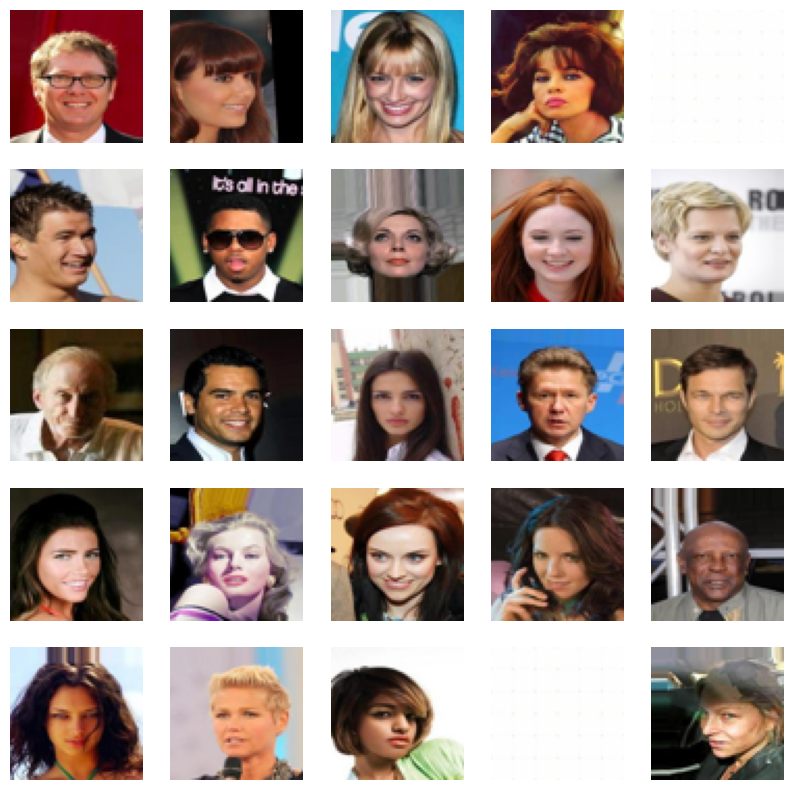

In [27]:
# Image Preprocessing: Load images from folder
real_images = load_images_from_folder(Real_Images_DIR, image_size=(WIDTH, HEIGHT))  # Load images and resize them to (64, 64)
print(f"Loaded {real_images.shape[0]} real images of size {real_images.shape[1:]}")
display_images(real_images)  # Display some of the images

In [28]:
# Get real image features
real_features = get_real_features(Real_Images_DIR)
print(f"Real features shape: {real_features.shape}")

Skipping non-image file: .DS_Store
Skipping non-image file: classification_results.csv
Skipping non-image file: best_gan_weights.weights.h5
Skipping non-image file: gan_weights.step_150.weights.h5
Skipping non-image file: gan_weights.step_100.weights.h5
Skipping non-image file: gan_weights.step_250.weights.h5
Skipping non-image file: gan_weights.step_400.weights.h5
Skipping non-image file: gan_weights.step_300.weights.h5
Skipping non-image file: gan_weights.step_350.weights.h5
Skipping non-image file: gan_weights.step_450.weights.h5
Skipping non-image file: gan_weights.step_200.weights.h5
Skipping non-image file: gan_weights.step_500.weights.h5
Skipping non-image file: gan_weights.step_50.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

# Creating Generator and Discriminator

In [29]:
# Creating Generator and Discriminator
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(generator, discriminator)

/Users/kyawkyawoo/Documents/Automation and Smart System/.venv/lib/python3.9/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [30]:
# Get generated image features (assuming you have a trained `generator`)
generated_features = get_generated_features(generator)  # Provide your trained generator
print(f"Generated features shape: {generated_features.shape}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━

# Generator Model Architecture

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8192)           │       270,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 64, 64, 3)      │        18,819 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,075,971 (4.10 MB)

 Trainable params: 1,075,971 (4.10 MB)

 Non-trainable params: 0 (0.00 B)

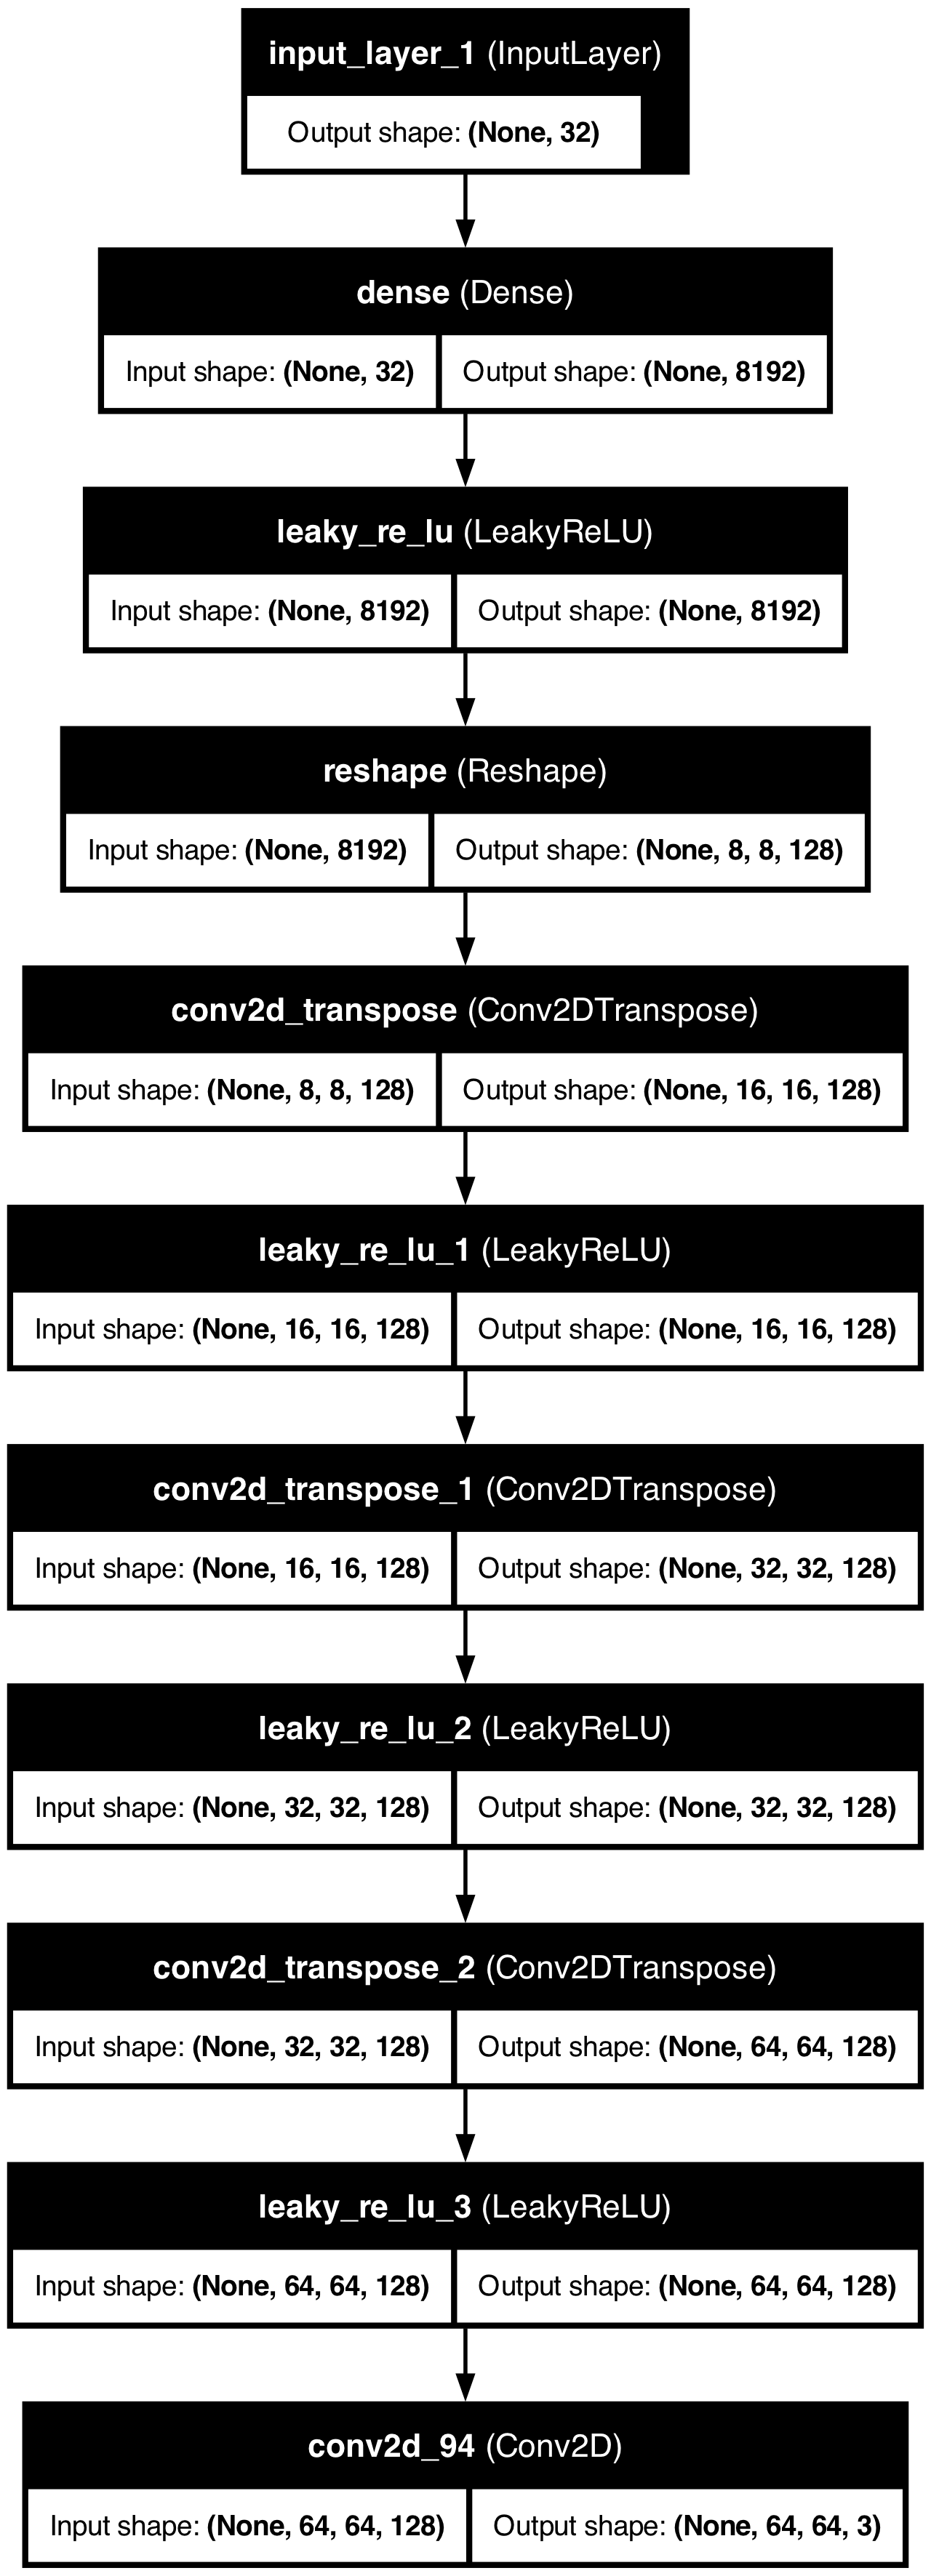

In [31]:
generator.summary()
plot_model(generator, to_file='generator_model.png', show_shapes=True, show_layer_names=True)

# Discriminator Model Architecture

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 64, 64, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_96 (Conv2D)              │ (None, 32, 32, 256)    │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_97 (Conv2D)              │ (None, 16, 16, 256)    │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_98 (Conv2D)              │ (None, 8, 8, 256)      │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_99 (Conv2D)              │ (None, 4, 4, 256)      │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,206,593 (16.05 MB)

 Trainable params: 4,206,593 (16.05 MB)

 Non-trainable params: 0 (0.00 B)

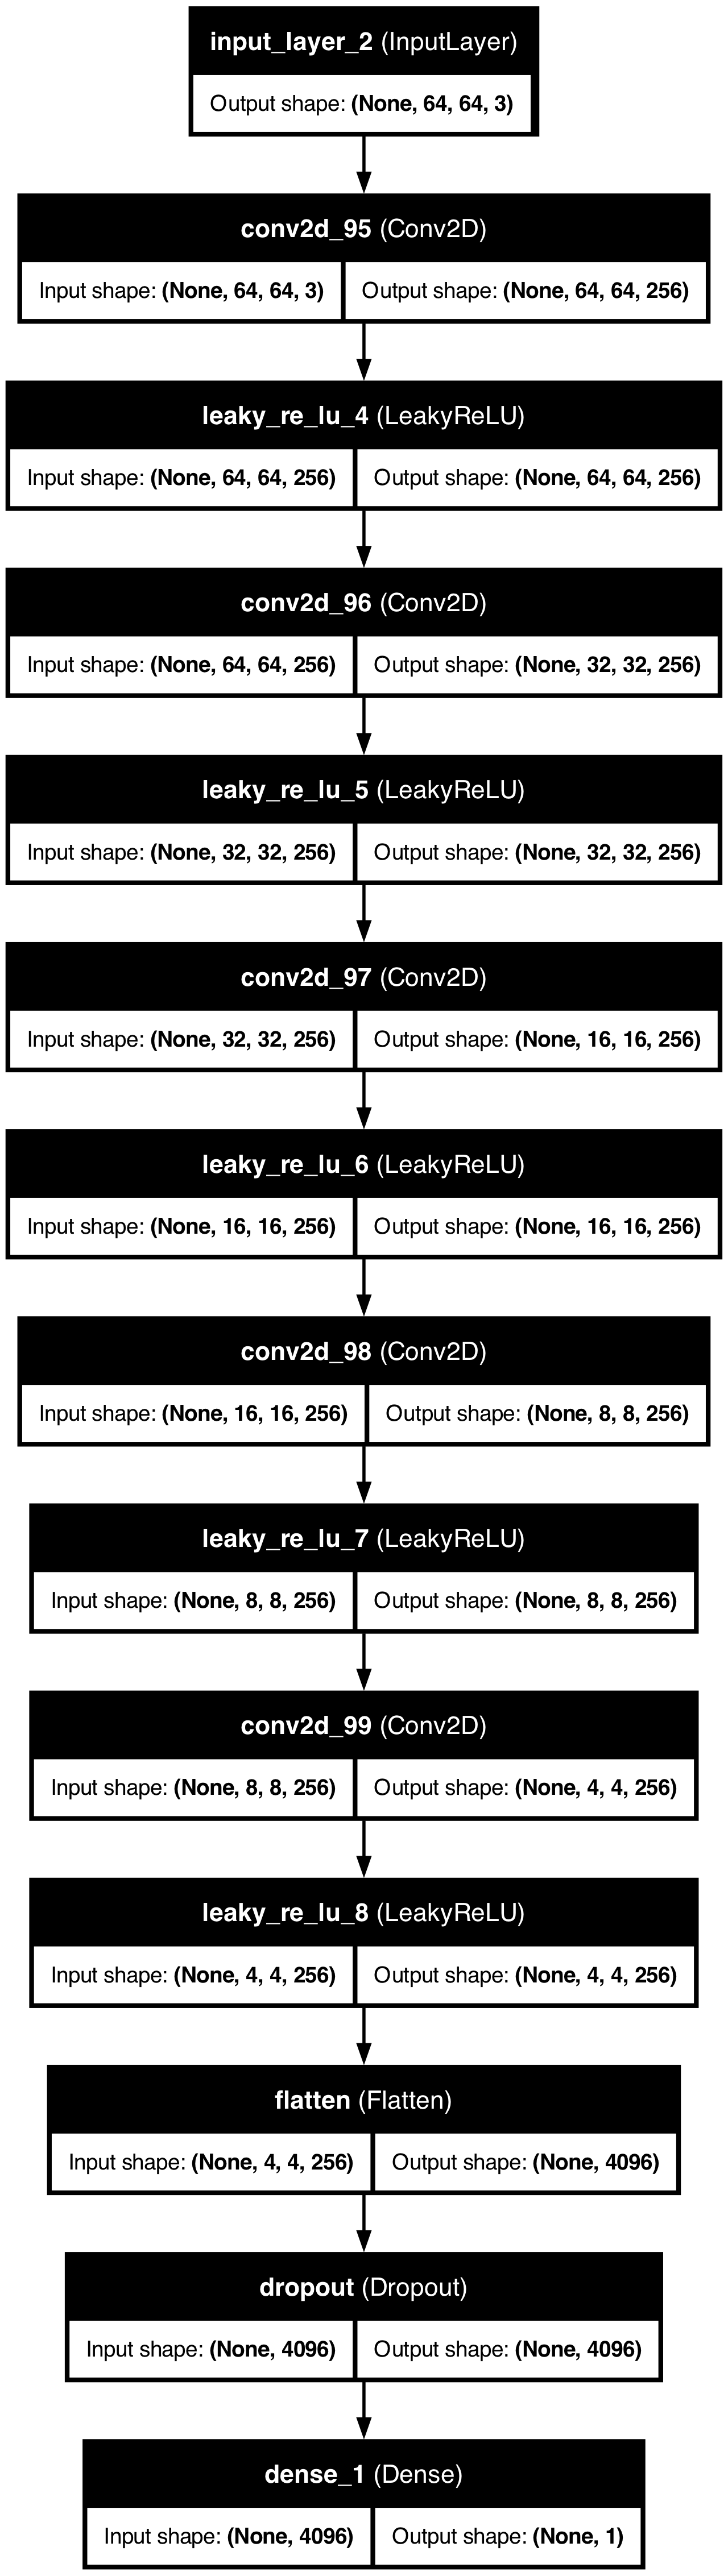

In [32]:
discriminator.summary()
plot_model(discriminator, to_file='discriminator_model.png', show_shapes=True, show_layer_names=True)

# GAN Model Architecture

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 64, 64, 3)      │     1,075,971 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 1)              │     4,206,593 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,282,564 (20.15 MB)

 Trainable params: 5,282,564 (20.15 MB)

 Non-trainable params: 0 (0.00 B)

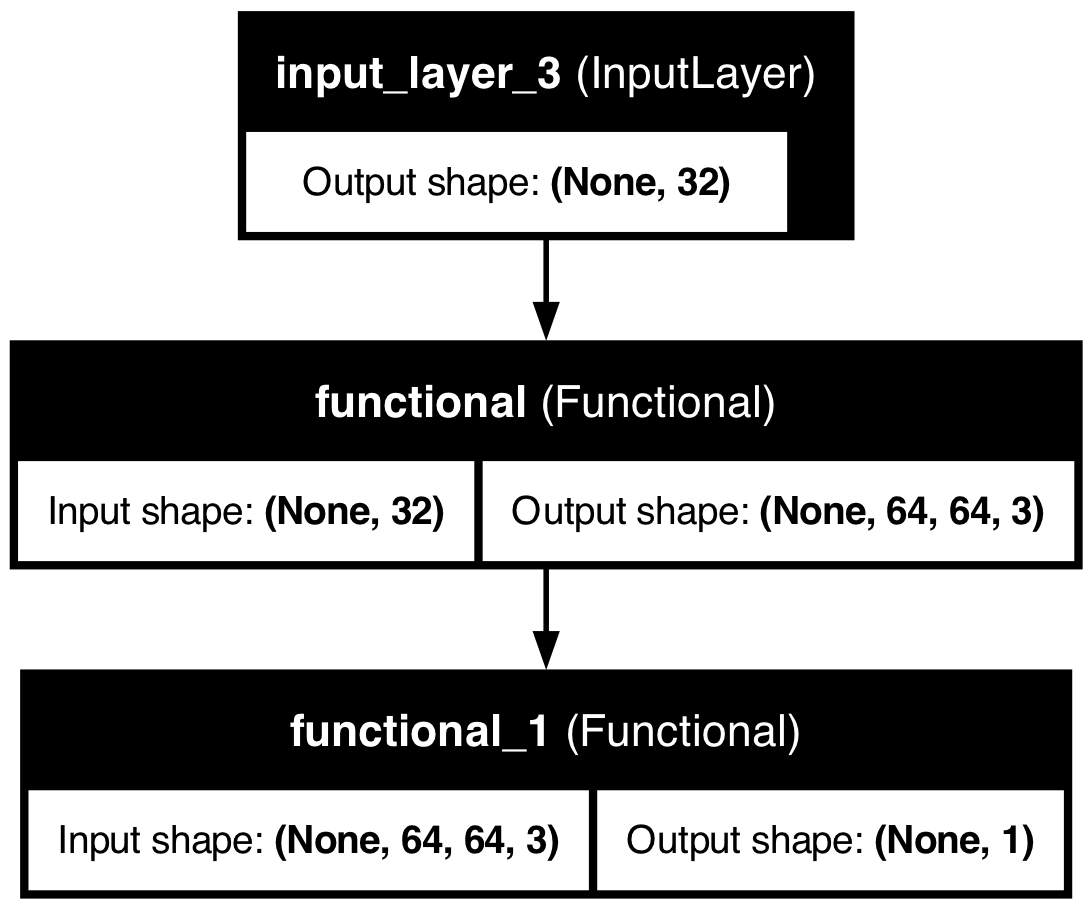

In [33]:
gan.summary()
plot_model(gan, to_file='gan_model.png', show_shapes=True, show_layer_names=True)

# GAN Model Training

In [ ]:
# Assuming generator, discriminator, and gan models are defined
# and images is the dataset you are using for training.

d_losses, a_losses, classification_df = train_gan_classification(generator, discriminator, gan, real_images, batch_size=16, iters=500, res_dir=Real_Images_DIR, file_path=FILE_PATH)

# View classification results as a Pandas DataFrame
print(classification_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


/Users/kyawkyawoo/Documents/Automation and Smart System/.venv/lib/python3.9/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms

# Display the Discrimination and Adversary Losses

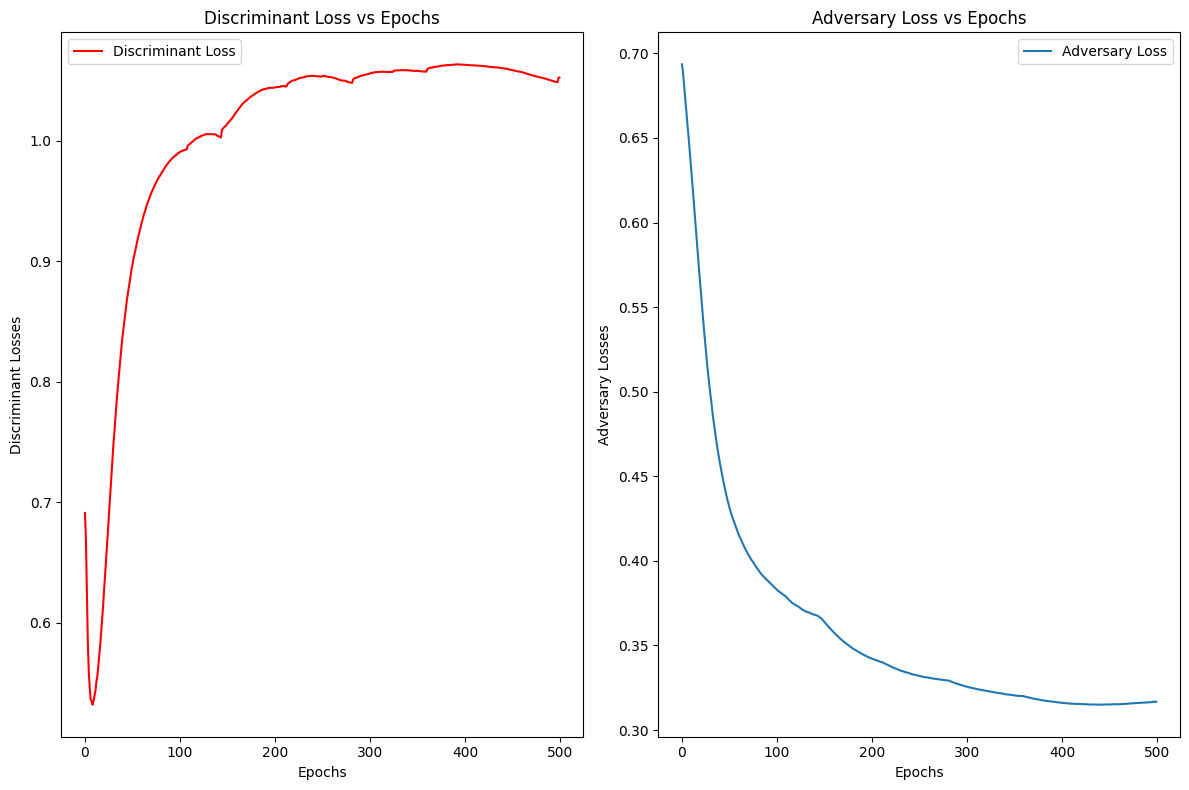

([array(0.69117856, dtype=float32),
  array(0.6679958, dtype=float32),
  array(0.6254519, dtype=float32),
  array(0.5827142, dtype=float32),
  array(0.55936253, dtype=float32),
  array(0.54588246, dtype=float32),
  array(0.53647804, dtype=float32),
  array(0.5351908, dtype=float32),
  array(0.5322311, dtype=float32),
  array(0.53533095, dtype=float32),
  array(0.53994894, dtype=float32),
  array(0.54385686, dtype=float32),
  array(0.5514963, dtype=float32),
  array(0.5561992, dtype=float32),
  array(0.5641909, dtype=float32),
  array(0.57315594, dtype=float32),
  array(0.58160776, dtype=float32),
  array(0.59232116, dtype=float32),
  array(0.6032762, dtype=float32),
  array(0.61348146, dtype=float32),
  array(0.6266759, dtype=float32),
  array(0.6380476, dtype=float32),
  array(0.65094614, dtype=float32),
  array(0.66249883, dtype=float32),
  array(0.6749758, dtype=float32),
  array(0.6884509, dtype=float32),
  array(0.70089185, dtype=float32),
  array(0.7129716, dtype=float32),
  arra

In [ ]:
# Call the plot_losses function
plot_losses(d_losses, a_losses, save_path='losses_epoch_500.png')
d_losses, a_losses

# Image Generation Model from the Generator Model

In [ ]:
# Assuming the generator is already trained and available:
generator = create_generator(latent_dim=LATENT_DIM, channels=CHANNELS, height=HEIGHT, width=WIDTH)

In [ ]:
# Generate fake images after training
num_fake_images = 10  # Number of fake images to generate
generated_fake_images = generate_images(generator, num_images=num_fake_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


In [ ]:
# Generate a batch of images
generated_images = generate_images(generator, num_images=100)  # Generate 100 images
generated_images_path = current_directory + '/Genarated_Images'
save_images_to_directory(generated_images,generated_images_path)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


# GAN Metrics like IScore, FID, Precision and Recall, KID

# IScore

In [ ]:
# Convert generated images to PIL format (if needed) for the Inception Score calculation
generated_images_pil = [Image.fromarray((img * 255).astype(np.uint8)) for img in generated_images]

# Calculate Inception Score
inception_score_value = inception_score(generated_images_pil, splits=10)
print(f"Inception Score: {inception_score_value}")

/Users/kyawkyawoo/Documents/Automation and Smart System/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kyawkyawoo/Documents/Automation and Smart System/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception Score: 1.2445997238159179


# FID

In [ ]:
# Calculate FID score
fid_score = calculate_fid(real_images, generated_images)
print(f"FID score: {fid_score}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 965ms/step
FID score: 3.383365248600155


# Precision and Recall for GANs

In [ ]:
def calculate_precision_recall(real_features, generated_features, k=5):
    """
    Calculate Precision and Recall for GANs.
    real_features: NumPy array of real image features (N x D)
    generated_features: NumPy array of generated image features (M x D)
    """
    # Nearest neighbors for precision (generated to real)
    nbrs_real = NearestNeighbors(n_neighbors=k).fit(real_features)
    _, indices_real = nbrs_real.kneighbors(generated_features)

    precision = np.mean([1.0 / k * np.sum(1.0 / (np.linalg.norm(generated_features[i] - real_features[indices_real[i]], axis=1))) for i in range(len(generated_features))])

    # Nearest neighbors for recall (real to generated)
    nbrs_gen = NearestNeighbors(n_neighbors=k).fit(generated_features)
    _, indices_gen = nbrs_gen.kneighbors(real_features)

    recall = np.mean([1.0 / k * np.sum(1.0 / (np.linalg.norm(real_features[i] - generated_features[indices_gen[i]], axis=1))) for i in range(len(real_features))])

    return precision, recall

In [ ]:
# Example: Assuming `real_features` and `generated_features` are feature tensors
precision, recall = calculate_precision_recall(real_features, generated_features)
print(f"Precision: {precision}, Recall: {recall}")

Precision: 0.04740079864859581, Recall: 0.04629025608301163


# Kernel Inception Distance (KID)

In [ ]:
def calculate_kid(real_features, generated_features, kernel='rbf', gamma=1.0):
    """
    Calculate Kernel Inception Distance (KID) between real and generated features.
    real_features: Tensor of real image features (N x D)
    generated_features: Tensor of generated image features (M x D)
    """
    # Compute the pairwise squared distances between features
    pairwise_real = pairwise_distances(real_features, metric='sqeuclidean')
    pairwise_gen = pairwise_distances(generated_features, metric='sqeuclidean')
    pairwise_cross = pairwise_distances(real_features, generated_features, metric='sqeuclidean')

    # Apply the Gaussian kernel (RBF kernel)
    kernel_real = np.exp(-gamma * pairwise_real)
    kernel_gen = np.exp(-gamma * pairwise_gen)
    kernel_cross = np.exp(-gamma * pairwise_cross)

    # Compute the mean and covariance
    mmd = np.mean(kernel_real) + np.mean(kernel_gen) - 2 * np.mean(kernel_cross)
    return mmd

In [ ]:
# Example: Assuming `real_features` and `generated_features` are feature tensors
kid = calculate_kid(real_features, generated_features)
print(f"KID: {kid}")

KID: 0.012501092002010751


Inception Score (IS): Measures the quality and diversity of the generated images by classifying them with a pre-trained Inception model.
Fréchet Inception Distance (FID): Measures the distance between the real and generated images in the feature space using the Inception model.
Precision and Recall for GANs: Measures the quality (precision) and diversity (recall) of generated images.
Kernel Inception Distance (KID): A robust alternative to FID, based on Maximum Mean Discrepancy (MMD) with a Gaussian kernel.